### Import

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re
import pandas as pd
import ast
import pickle
from itertools import combinations

### Utils

In [4]:
def parse_abs_text(text: str) -> dict:
    """
    Parse le contenu d'un fichier .abs (meta arXiv) et renvoie un dict
    avec les principaux champs.
    """
    rec = {
        "paper_id": None,
        "from_field": None,
        "date": None,
        "title": None,
        "authors_raw": None,
        "subj_class": None,
        "journal_ref": None,
        "comments": None,
    }

    for line in text.splitlines():
        line = line.rstrip()

        if line.startswith("Paper:"):
            # ex: "Paper: hep-th/9201001"
            rec["paper_id"] = line.split(":", 1)[1].strip()

        elif line.startswith("From:"):
            rec["from_field"] = line.split(":", 1)[1].strip()

        elif line.startswith("Date:"):
            rec["date"] = line.split(":", 1)[1].strip()

        elif line.startswith("Title:"):
            rec["title"] = line.split(":", 1)[1].strip()

        elif line.startswith("Authors:"):
            authors = line.split(":", 1)[1].strip()
            rec["authors_raw"] = authors

        elif line.startswith("Comments:"):
            rec["comments"] = line.split(":", 1)[1].strip()

        elif line.startswith("Subj-class:"):
            rec["subj_class"] = line.split(":", 1)[1].strip()

        elif line.startswith("Journal-ref:"):
            rec["journal_ref"] = line.split(":", 1)[1].strip()

    return rec




<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

# CA-HepTh Dataset — Summary

**What it is**
A **collaboration network** of authors in the *High Energy Physics – Theory* (hep-th) category on **arXiv**. It covers submissions from **January 1993 to April 2003**.
This is split into 2 part,

1st, a list of the relation between the authors
- Each **node = an author ID**, each **edge = at least one co-authored paper ID** (undirected).
- Network scale: **9,877 nodes** and **51,971 edges**.

2nd, a list of metadata for the papers with a file per paper containing,
- The **abstract** of the paper 
- The publiation **date**
- The **names** of the authors
- Number of files **29555**

The goal is to captures how scientific communities structure themselves through joint publications.

**Why it matters**
- Used to study **network properties** such as degree distribution, clustering, small-world effects, and community formation.
- Frequently referenced in network science (e.g., Newman, *PNAS*, 2001) as a benchmark for **real-world collaboration graphs**.

## Why I chose it
- It connects data analysis with **theoretical physics**, a field I genuinely enjoy.
- The dataset reflects **real scientific relationships**, not synthetic or abstract graphs.
- Perfect to explore how physicists collaborate and how knowledge spreads within a research community.

**Source:** Stanford SNAP — https://snap.stanford.edu/data/ca-HepTh.html

<ul></div>





## Load Metadata and clean them
The dataset is separate in 2 parts, 
- A file with the connexion between the paper id (ex. 1394 -> 3442)
- A folder with all the metadata per year with the author, the date, the mail, the abstract of the paper,...

However there is no file that link author id to paper id so this 2 parts are not joinable directly

### Cleaning the author part

In [ ]:
# path = "CA-HepTh.txt"

# meta_root = Path("paper_meta_info")

# records = []

# for abs_path in meta_root.rglob("*.abs"):
#     # year = nom du dossier parent (1992, 1993, etc.)
#     year = abs_path.parent.name

#     with open(abs_path, encoding="latin-1") as f:
#         text = f.read()

#     rec = parse_abs_text(text)
#     rec["year"] = int(year)
#     rec["file_path"] = str(abs_path)

#     records.append(rec)

# meta_df = pd.DataFrame(records)

# print("Nombre de métadonnées chargées :", len(meta_df))
# meta_df.head()

# def clean_paper_id(pid):
#     if pd.isna(pid) or pid is None:
#         return None
#     # Extract only the numeric part after the slash
#     if '/' in pid:
#         return pid.split('/')[-1]
#     return pid

# meta_df["paper_id"] = meta_df["paper_id"].apply(clean_paper_id)


# def split_authors(raw):
#     if pd.isna(raw):
#         return []
    
#     txt = raw.replace(" and ", ",")
#     parts = [a.strip() for a in txt.split(",")]
#     return [p for p in parts if p]

# meta_df["authors_list"] = meta_df["authors_raw"].apply(split_authors)

# def clean_email(raw):
#     if pd.isna(raw):
#         return None

#     txt = raw.strip().lower()

#     # supprimer éventuels <...> ou (...)
#     txt = re.sub(r"<([^>]+)>", r"\1", txt)
#     txt = re.sub(r"\(([^)]+)\)", "", txt)

#     # remplacer les % par @ si format BITNET/anciens serveurs
#     txt = txt.replace("%", "@")

#     # extraire la chaîne type "xxx@yyy.zzz"
#     m = re.search(r"[a-z0-9._\-]+@[a-z0-9._\-]+\.[a-z]{2,}", txt)
#     if m:
#         return m.group(0)

#     return None

# meta_df["email"] = meta_df["from_field"].apply(clean_email)
# meta_df = meta_df.drop(columns=["from_field"])
# # Reorder columns to move email to second position
# cols = meta_df.columns.tolist()
# cols.remove('email')
# cols.insert(1, 'email')
# meta_df = meta_df[cols]


# meta_df["authors_list"] = meta_df["authors_list"].apply(
#     lambda x: ast.literal_eval(x) if isinstance(x, str) else []
# )

# meta_df.head()

# meta_df.to_csv("arxiv_hepth_meta.csv", index=False)


In [44]:
meta_df = pd.read_csv("arxiv_hepth_meta.csv")
print(meta_df["n_authors"].describe())
meta_df.head()

count    29555.000000
mean         1.828997
std          1.201099
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: n_authors, dtype: float64


paper_id                          email  \
0   9201001   zuber@poseidon.saclay.cea.fr   
1   9201002             tarlini@fi.infn.it   
2   9201003        dijkgraaf@iassns.bitnet   
3   9201004  nathan@max.physics.sunysb.edu   
4   9201005       irk@pupthy.princeton.edu   

                                          date  \
0  Tue Dec 31 23:54:17 MET 1991 +0100   (37kb)   
1                Thu, 2 JAN 92 12:17 N   (6kb)   
2             Thu, 2 Jan 92 14:06 EST   (54kb)   
3          Thu, 2 Jan 92 20:02:01 EST   (21kb)   
4           Fri, 3 Jan 92 17:09:04 est   (8kb)   

                                               title  \
0  Combinatorics of the Modular Group II: the Kon...   
1  Inomogeneous Quantum Groups as Symmetries of P...   
2  Intersection Theory, Integrable Hierarchies an...   
3  The Heterotic Green-Schwarz Superstring on an ...   
4   Ward Identities in Two-Dimensional String Theory   

                                         authors_raw  \
0                        C. Itzykson and J.-B. Zuber   
1  F.Bonechi, E.Celeghini, R.Giachetti, E.Sorace ...   
2                                  Robbert Dijkgraaf   
3                                   Nathan Berkovits   
4                                   Igor R. Klebanov   

                                      subj_class  \
0  High Energy Physics - Theory; Quantum Algebra   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

                           journal_ref  \
0  Int.J.Mod.Phys. A7 (1992) 5661-5705   
1   Phys.Rev.Lett. 68 (1992) 3718-3720   
2                                  NaN   
3        Nucl.Phys. B379 (1992) 96-120   
4   Mod. Phys. Lett. A7 (1992) 723-732   

                                            comments  year  \
0                                           46 pages  1992   
1                                     5 pags. 0 figs  1992   
2  73 pages, most figures are not included. Lectu...  1992   
3                                           33 pages  1992   
4                                           12 pages  1992   

                          file_path  \
0  paper_meta_info\1992\9201001.abs   
1  paper_meta_info\1992\9201002.abs   
2  paper_meta_info\1992\9201003.abs   
3  paper_meta_info\1992\9201004.abs   
4  paper_meta_info\1992\9201005.abs   

                                        authors_list  n_authors  
0                     ['C. Itzykson', 'J.-B. Zuber']          2  
1  ['F.Bonechi', 'E.Celeghini', 'R.Giachetti', 'E...          5  
2                              ['Robbert Dijkgraaf']          1  
3                               ['Nathan Berkovits']          1  
4                               ['Igor R. Klebanov']          1

### Recreate the graph

In [40]:
# G_authors = nx.Graph()

# for _, row in meta_df.iterrows():
#     paper = row["paper_id"]
#     authors = row["authors_list"]
#     year = row["year"]

#     # Sauter les papiers sans auteurs
#     if not authors:
#         continue

#     # Ajouter les auteurs + attributs
#     for a in authors:
#         if not G_authors.has_node(a):
#             G_authors.add_node(a, papers=set(), years=set())
#         G_authors.nodes[a]["papers"].add(paper)
#         G_authors.nodes[a]["years"].add(year)

#     # Ajouter les relations entre co-auteurs
#     for a1, a2 in combinations(authors, 2):
#         if G_authors.has_edge(a1, a2):
#             G_authors[a1][a2]["weight"] += 1
#         else:
#             G_authors.add_edge(a1, a2, weight=1)

# # Convertir sets → listes (plus pratique pour sérialisation / affichage)
# for a in G_authors.nodes():
#     G_authors.nodes[a]["papers"] = list(G_authors.nodes[a]["papers"])
#     G_authors.nodes[a]["years"] = sorted(G_authors.nodes[a]["years"])

# print(f"Graph - Nodes: {G_authors.number_of_nodes()}, Edges: {G_authors.number_of_edges()}")


# with open("G_authors.gpickle", "wb") as f:
#     pickle.dump(G_authors, f)

Graph - Nodes: 17816, Edges: 28114


In [45]:
# Load the graph from the file
with open("G_authors.gpickle", "rb") as f:
	G_authors = pickle.load(f)

# Verify the loaded graph has the same properties
print(f"Graph - Nodes: {G_authors.number_of_nodes()}, Edges: {G_authors.number_of_edges()}")

Graph - Nodes: 17816, Edges: 28114


### Load the real graph

In [19]:
path = "CA-HepTh.txt"

G_papers = nx.read_edgelist(
    path,
    comments="#",
    delimiter="\t",
    nodetype=int,
    create_using=nx.Graph()
)

# Check id the properties of the graph G
print(G_papers.number_of_nodes(), "nodes")
print(G_papers.number_of_edges(), "edges")

9877 nodes
25998 edges


<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>


| **Metric** | **Exported Data** | **Built Data** |
|------------|-----------|-------------|
| **Author - Nodes** | 9,877 | 17816 |
| **Links - Edges** | 25998  | 28114 |

Here it is clear that the re-built dataset have the same order of magnitude as the downloaded one.
However there is 2 times more authors in the built one and this might be cause of some duplication in the names. In did it is known that the scientist names are not always consistent in publications. Exemple A.Michel, Alexandre Michel, MICHEL Alexandre will be gonna be considered as 3 diffrent authors in the built data.

<ul></div>

<div style="background-color: #e3f2fd; border: 2px solid #2196f3; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #1976d2; margin-top: 0;">Context</h4>

# Vizualization

This part is dedicated to exeplore vizually the graph.

<h4 style="color: #d21919ff; margin-top: 0;">To complete</h4>


<ul></div>





Create a subgraph to simplify the computation

In [ ]:
G = G_authors

top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:100]
sub_nodes = [n for n, _ in top_nodes]
H = G.subgraph(sub_nodes)

<div style="background-color: #f2eec7ff; border: 2px solid #baaf5bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #baaf5bff; margin-top: 0;">Note</h4>

Here a important part of the visualization was made using `Claude Sonet 4` to help me build a vizualy pleasent plot

<ul></div>

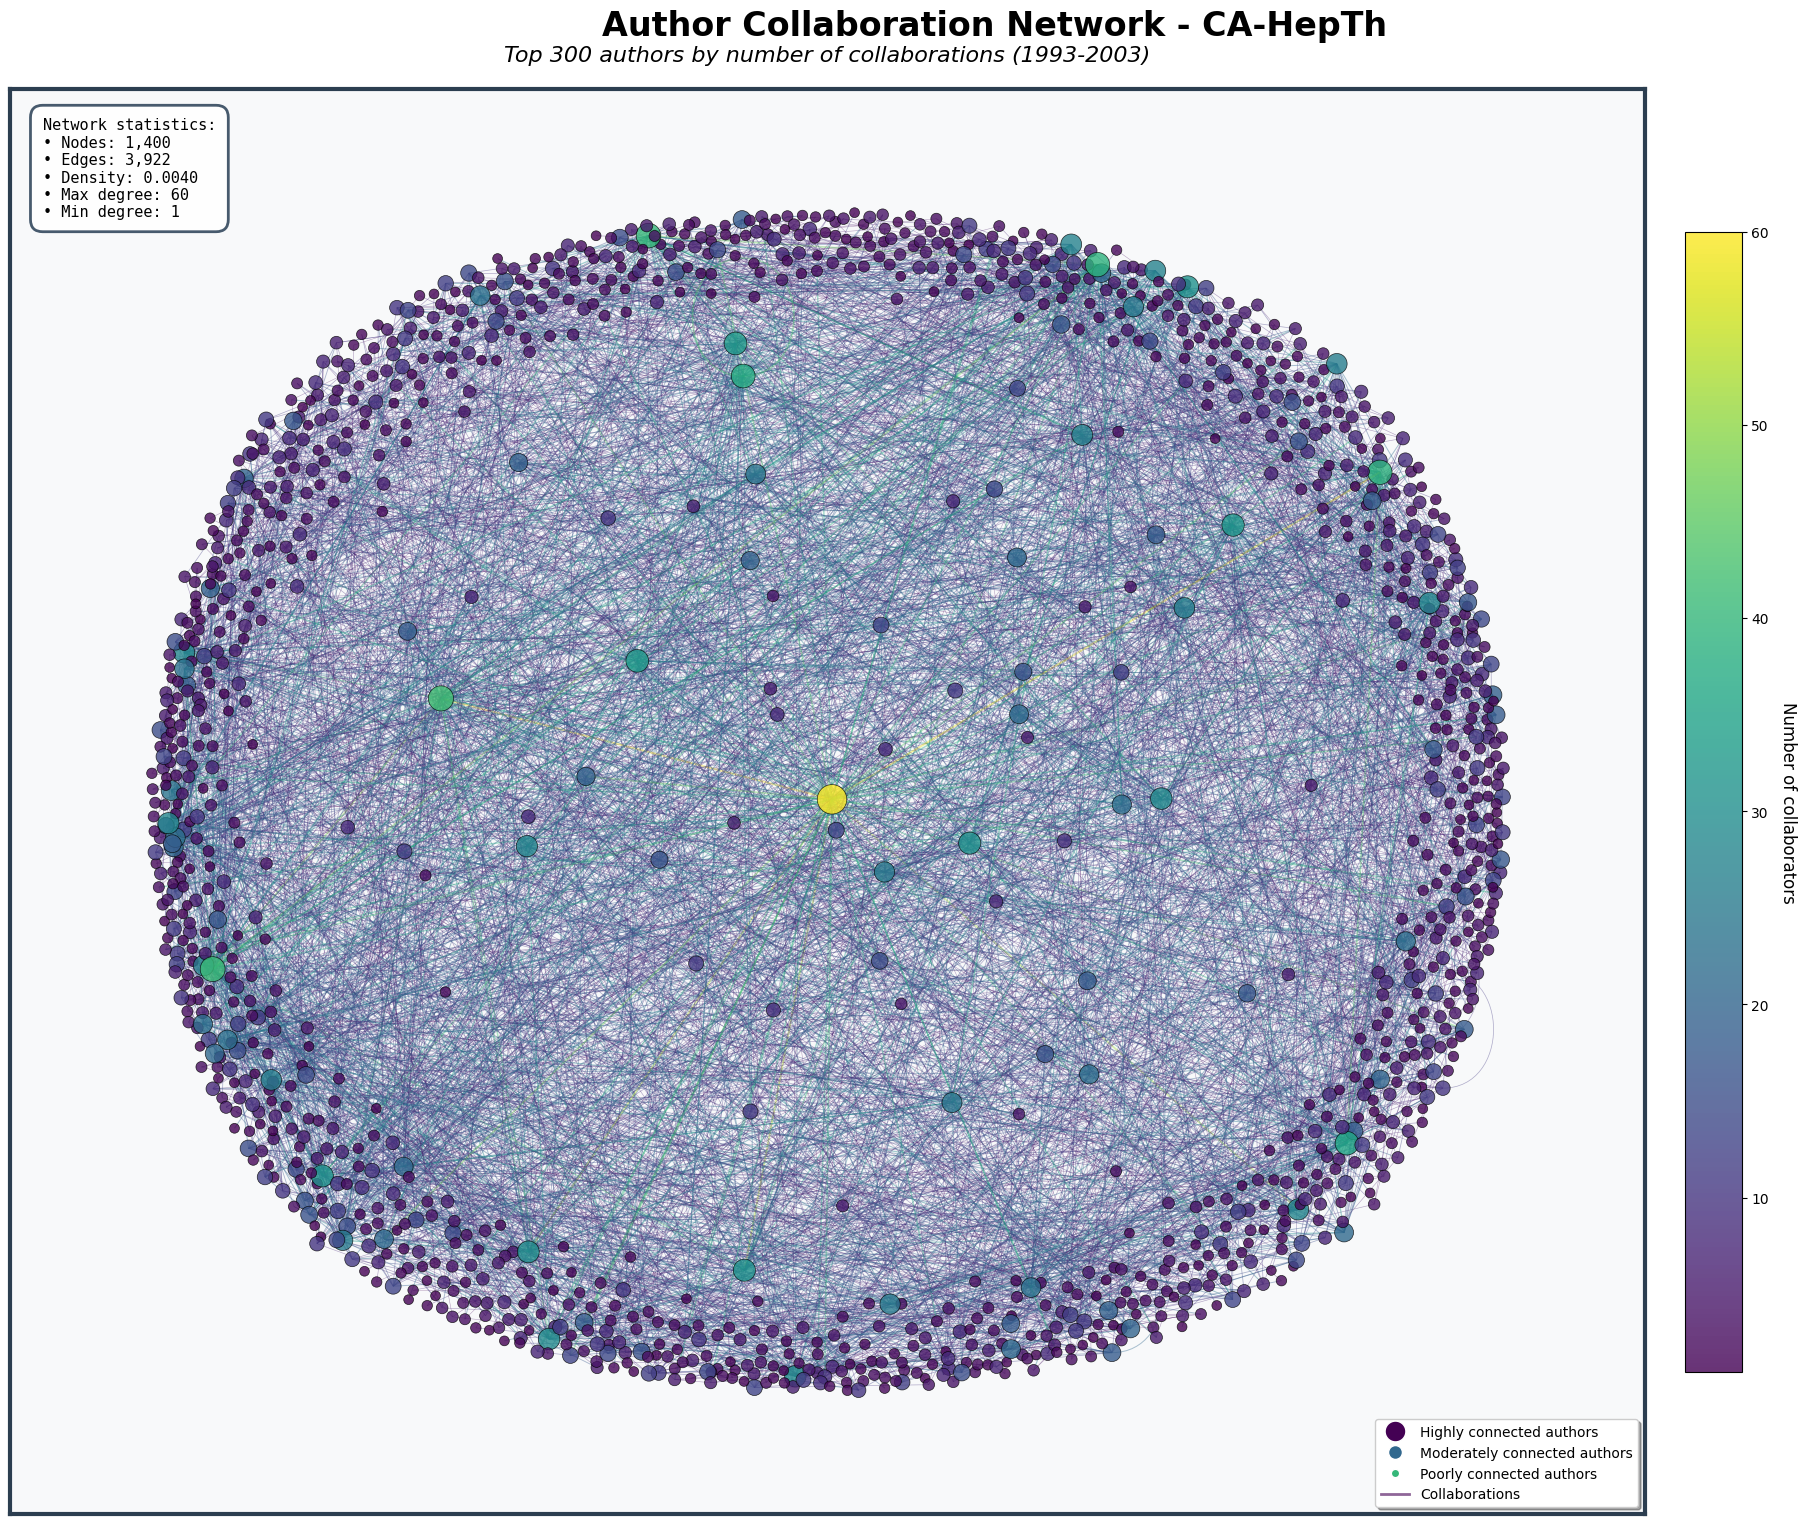

In [65]:
def compute_edge_properties(H):
    """Computes visual properties of edges based on node degrees."""
    edge_colors = []
    edge_widths = []
    max_degree = max([H.degree[n] for n in H.nodes()])
    
    for edge in H.edges():
        # Color based on the sum of connected nodes' degrees
        degree_sum = H.degree[edge[0]] + H.degree[edge[1]]
        edge_colors.append(degree_sum)
        edge_widths.append(0.3 + (degree_sum / max_degree * 0.7))
    
    return edge_colors, edge_widths

def compute_node_properties(H):
    """Computes visual properties of nodes based on their degrees."""
    node_colors = [H.degree[node] for node in H.nodes()]
    max_degree = max([H.degree[n] for n in H.nodes()])
    min_degree = min([H.degree[n] for n in H.nodes()])
    
    # Node sizes proportional to degree with extended range
    node_sizes = [50 + (H.degree[node] - min_degree) / (max_degree - min_degree) * 400 
                  for node in H.nodes()]
    
    return node_colors, node_sizes, max_degree, min_degree

def draw_network_edges(H, pos, ax):
    """Draws network edges with computed colors and widths."""
    edge_colors, edge_widths = compute_edge_properties(H)
    
    nx.draw_networkx_edges(H, pos, 
                          edge_color=edge_colors, 
                          edge_cmap=plt.cm.viridis,
                          width=edge_widths,
                          alpha=0.4,
                          ax=ax)

def draw_network_nodes(H, pos, ax):
    """Draws network nodes with computed colors and sizes."""
    node_colors, node_sizes, max_degree, min_degree = compute_node_properties(H)
    
    nodes = nx.draw_networkx_nodes(H, pos, 
                                  node_color=node_colors,
                                  node_size=node_sizes,
                                  cmap=plt.cm.viridis,
                                  alpha=0.8,
                                  edgecolors='black',
                                  linewidths=0.5,
                                  ax=ax)
    
    return nodes, max_degree, min_degree

def add_titles_and_labels(fig, ax):
    """Adds main titles and subtitles."""
    fig.suptitle('Author Collaboration Network - CA-HepTh', 
                 fontsize=24, fontweight='bold', y=0.95)
    ax.set_title('Top 300 authors by number of collaborations (1993-2003)', 
                 fontsize=16, pad=20, style='italic')

def add_colorbar(nodes, ax):
    """Adds explanatory colorbar."""
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Number of collaborators', rotation=270, labelpad=20, fontsize=12)
    return cbar

def add_decorative_frame(ax):
    """Adds decorative frame around the plot."""
    for spine in ax.spines.values():
        spine.set_edgecolor('#2c3e50')
        spine.set_linewidth(3)

def add_statistics_box(H, max_degree, min_degree, ax):
    """Adds a box with network statistics."""
    textstr = f'''Network statistics:
• Nodes: {H.number_of_nodes():,}
• Edges: {H.number_of_edges():,}
• Density: {nx.density(H):.4f}
• Max degree: {max_degree}
• Min degree: {min_degree}'''

    props = dict(boxstyle='round,pad=0.8', facecolor='white', alpha=0.9, 
                 edgecolor='#34495e', linewidth=2)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props, family='monospace')

def add_custom_legend(ax):
    """Adds custom legend with viridis colors."""
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#440154', 
               markersize=15, label='Highly connected authors'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#31688e', 
               markersize=10, label='Moderately connected authors'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#35b779', 
               markersize=6, label='Poorly connected authors'),
        Line2D([0], [0], color='#440154', linewidth=2, alpha=0.6, label='Collaborations')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
              fancybox=True, shadow=True, fontsize=10)

def configure_axes(ax):
    """Configures axes and adds subtle grid."""
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.5)

def plot_collaboration_network(H, figsize=(20, 16)):
    """
    Main function to display collaboration network with all visual enhancements.
    
    Parameters:
    -----------
    H : networkx.Graph
        The subgraph to visualize
    figsize : tuple
        Figure size (width, height)
    """
    # Style configuration and figure creation
    plt.style.use('default')
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, facecolor='#f8f9fa')
    
    # Computing node positions with improved layout
    pos = nx.spring_layout(H, seed=42, k=1.5, iterations=50)
    
    # Drawing the network
    draw_network_edges(H, pos, ax)
    nodes, max_degree, min_degree = draw_network_nodes(H, pos, ax)
    
    # Adding visual elements
    add_titles_and_labels(fig, ax)
    add_colorbar(nodes, ax)
    add_decorative_frame(ax)
    add_statistics_box(H, max_degree, min_degree, ax)
    add_custom_legend(ax)
    configure_axes(ax)
    
    # Layout adjustment
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    plt.show()

# Main function call
plot_collaboration_network(H)

<div style="background-color: #c7f2d3ff; border: 2px solid #5bba6bff; border-radius: 10px; padding: 15px; margin: 10px 0;">

<h4 style="color: #5bba6bff; margin-top: 0;">Results</h4>

As we can expect from the dataset statistics, there are few authors who appear very central in the community and a vast majority with fewer collaborations. This power-law distribution is characteristic of scale-free networks, where a small number of highly connected "hubs" coexist with many nodes having only a few connections.

**Key Observations:**

| **Metric** | **Value** |
|------------|-----------|
| **Mean authors per paper** | 1.83 |
| **Standard deviation** | 1.20 |
| **Median (50th percentile)** | 2 authors |
| **75th percentile** | 3 authors |
| **Maximum** | 8 authors |

This indicates that:
- **Solo publications** are common (25% of papers have ≤1 author)
- **Small collaborations** dominate (75% of papers have ≤3 authors)
- **Large collaborations** are rare but present (max 8 authors per paper)

The visualization confirms this hierarchical structure, where highly connected authors (shown in bright yellow/green) act as **central hubs** linking different research subgroups, while the majority of authors (darker nodes) maintain more localized collaboration patterns within their immediate research communities.

<ul></div>

Central node: and


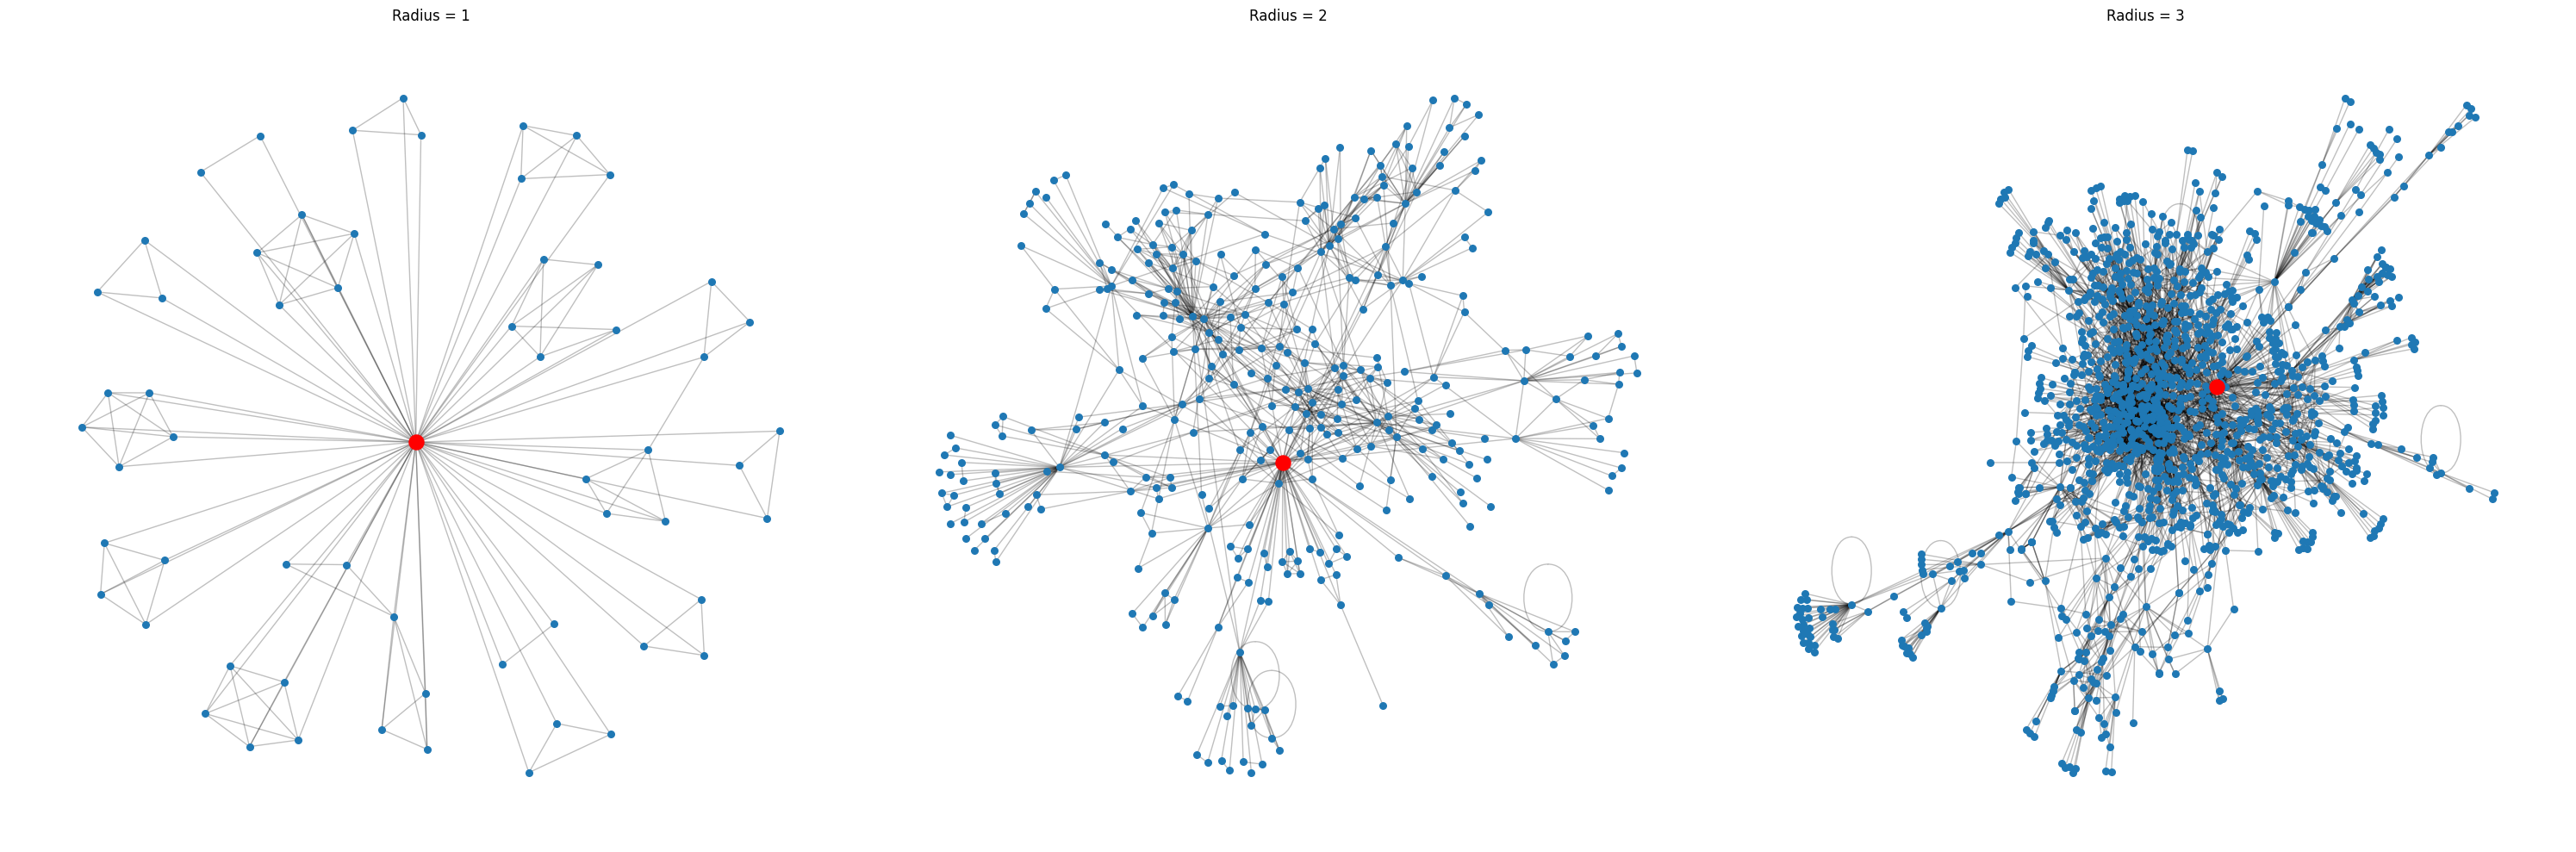

In [ ]:
def show_graph_from_center(H, central_node, ax, title=None):
    pos = nx.spring_layout(H, seed=42)

    # dessiner sur l'axe donné
    nx.draw_networkx_nodes(H, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(H, pos, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(H, pos, nodelist=[central_node], node_size=150, node_color="red", ax=ax)

    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)

central_node = max(G.degree, key=lambda x: x[1])[0]
print("Central node:", central_node)

# une seule figure avec 3 colonnes
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for ax, radius in zip(axes, [1, 2, 3]):
    H = nx.ego_graph(G, central_node, radius=radius)
    show_graph_from_center(H, central_node, ax, title=f"Radius = {radius}")

plt.tight_layout()
plt.show()


## Centrality Analysis

In a collaboration network like **CA-HepTh**, centrality measures help identify
not just *who collaborates the most*, but also *who connects scientific sub-communities*.

We will use two metrics describe **different roles**:
- Degree → *popularity / collaboration volume*
- Betweenness → *strategic position / connectivity across communities*

### Degree Centrality — *local visibility*
- Measures how many **distinct co-authors** an author has.
- High-degree nodes correspond to **highly active or prolific researchers**.
- Captures **local influence** within the collaboration network.

In [43]:
deg_centrality = nx.degree_centrality(G)

# top 10 authors with highest degree centrality
top_degree = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_degree

[(1441, 0.006581611988659377),
 (19615, 0.006075334143377886),
 (63113, 0.0059740785743215875),
 (30744, 0.005670311867152693),
 (16164, 0.0054678007290400975),
 (59077, 0.005366545159983799),
 (23420, 0.005366545159983799),
 (48973, 0.005164034021871203),
 (44262, 0.005164034021871203),
 (13648, 0.005062778452814905)]

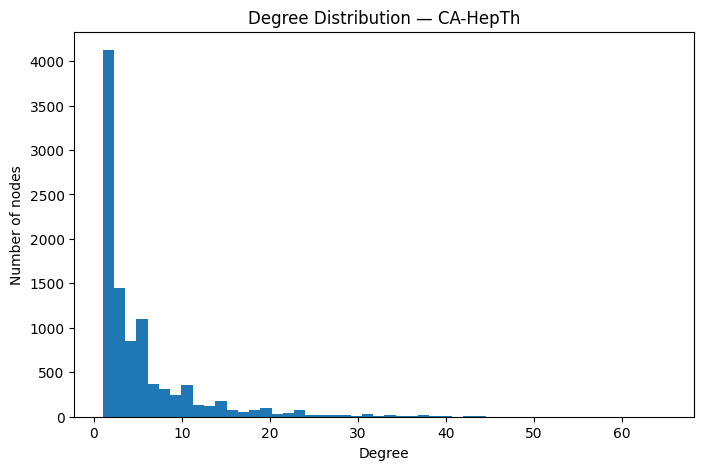

In [44]:
degrees = [d for _, d in G.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution — CA-HepTh")
plt.show()

### Betweenness Centrality — *structural brokerage*
- Measures how often a node lies on **shortest paths** between others.
- High-betweenness nodes act as **bridges between research groups**.
- Identifies **knowledge brokers** connecting subfields of theoretical physics.

In [45]:
bc = nx.betweenness_centrality(G, k=500, seed=42)

# top 10 authors with highest betweenness
top_betweenness = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness


[(44262, 0.02446894898693317),
 (19615, 0.021759279142174313),
 (30744, 0.02163464124977871),
 (43226, 0.01824221940720516),
 (14017, 0.015473962615790086),
 (62227, 0.014537534398902336),
 (37780, 0.0139804949678327),
 (24394, 0.013525827506633864),
 (1441, 0.0127018205618928),
 (33715, 0.012462022313576198)]

## Degree vs Betweenness — Comparison

This scatter shows how **activity (degree)** relates to **structural position (betweenness)**.
- Nodes high in both = **central hubs linking major groups**
- High degree but low betweenness = **local stars** inside dense communities
- Low degree but high betweenness = **rare bridges** connecting otherwise distant areas


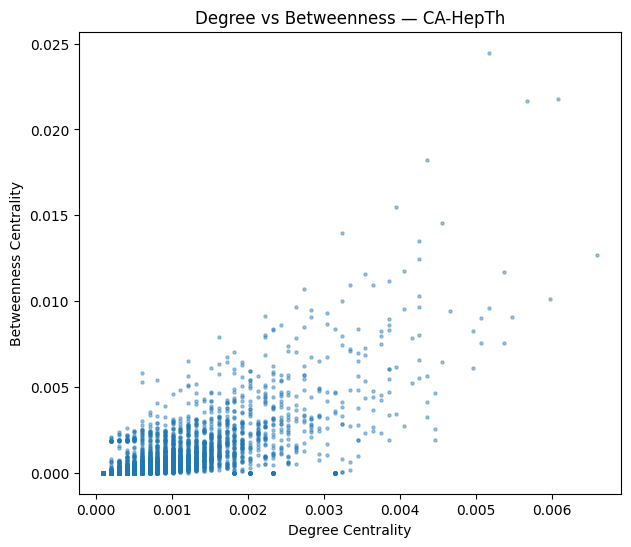

In [46]:
plt.figure(figsize=(7,6))
plt.scatter(
    [deg_centrality[n] for n in G.nodes()],
    [bc[n] for n in G.nodes()],
    s=5, alpha=0.4
)

plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Degree vs Betweenness — CA-HepTh")
plt.show()